# Load Library and Data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
import pyspark.pandas as ps

from datetime import datetime, date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder.appName('South German Credit - Customer Segmentation').getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.maxNumRows', 5)
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [2]:
sdf = spark.read.csv('SouthGermanCredit.csv', header=True, inferSchema=True)
sdf_encoded = spark.read.csv('SouthGermanCredit.asc', sep=' ', header=True)

# EDA

In [3]:
psdf = sdf.toPandas()

### Data Distribution
- kebanyakan credit card mempunyai amount 1500 - 4000
- distribusi dari data credit amount adalah positif

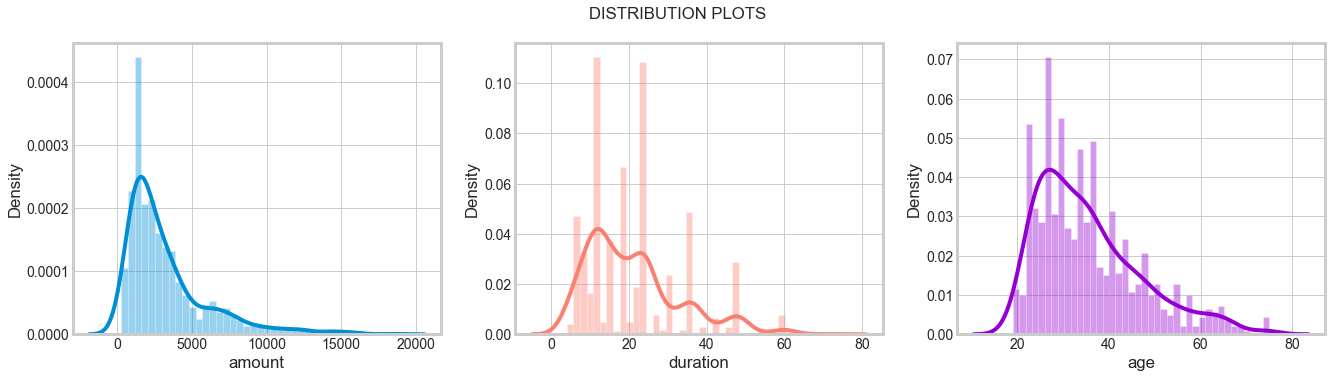

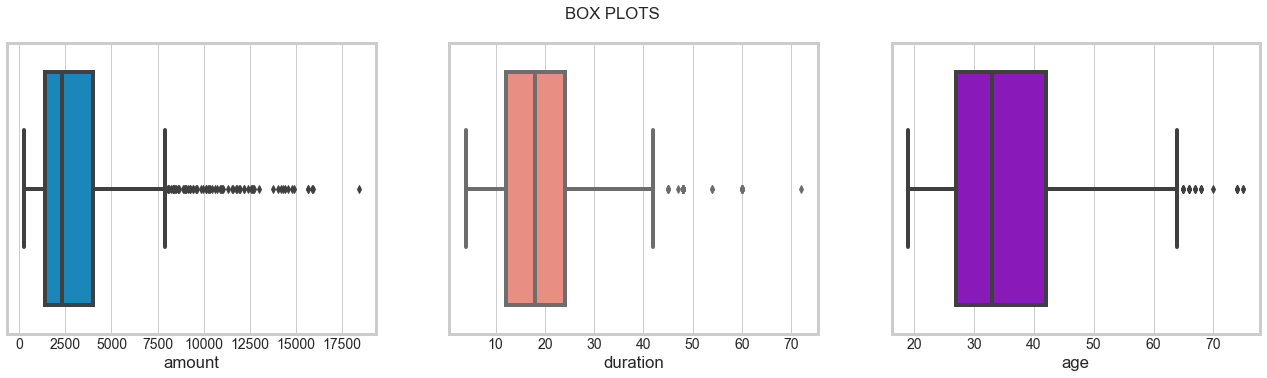

In [4]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle('DISTRIBUTION PLOTS')
sns.distplot(psdf['amount'], bins=40, ax=ax[0]);
sns.distplot(psdf['duration'], bins=40, ax=ax[1], color='salmon');
sns.distplot(psdf['age'], bins=40, ax=ax[2], color='darkviolet');

fig, ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle('BOX PLOTS')
sns.boxplot(psdf['amount'], ax=ax[0]);
sns.boxplot(psdf['duration'], ax=ax[1], color='salmon');
sns.boxplot(psdf['age'], ax=ax[2], color='darkviolet');

#### Credit Amount x Duration
- semakin besar credit yang diambil maka, semakin lama pula periode pembayarannya

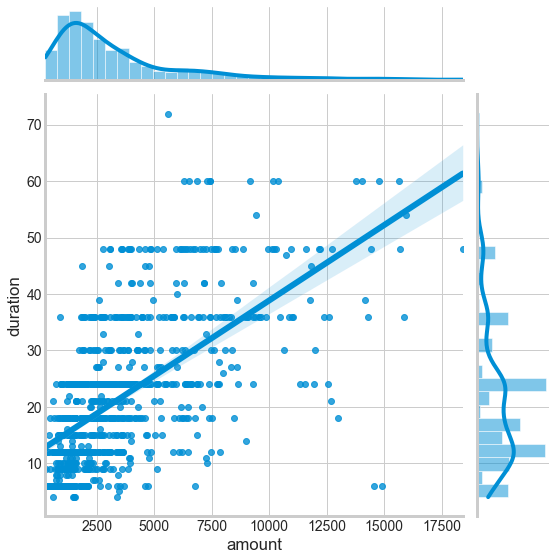

In [5]:
import scipy.stats as stats
r1 = sns.jointplot(x="amount",y="duration", data=psdf, kind="reg", height=8)
plt.show()

### Savings Analysis
- kebanyakan orang yang mengambil credit tidak mempunyai akun tabungan dan untuk setiap kategori tabungan
- orang yang mempunyai credit risk bad cenderung mengambil credit amount yang lebih besar

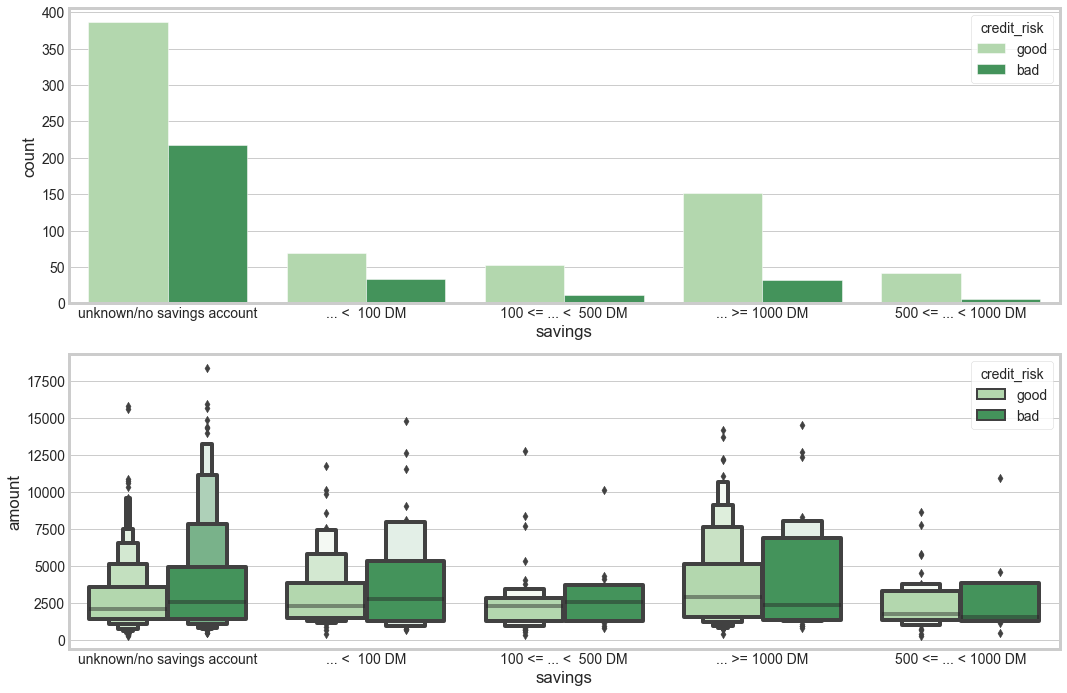

In [6]:
fig, ax =plt.subplots(2,1,figsize=(15,10))
plt.tight_layout(2)

sns.countplot(psdf['savings'], hue=psdf['credit_risk'], ax=ax[0], palette='Greens');
sns.boxenplot(psdf['savings'], psdf['amount'], hue=psdf['credit_risk'], ax=ax[1], palette='Greens');

### Credit Card Purpose Analysis

- orang yang mengambil credit dengan tujuan untuk membeli mobil, retraining, dan furniture cenderung memiliki credit risk yang baik
- orang yang mengambil pinjaman besar untuk membeli mobil baru dan membuka bisnis cenderung memiliki credit risk yang buruk

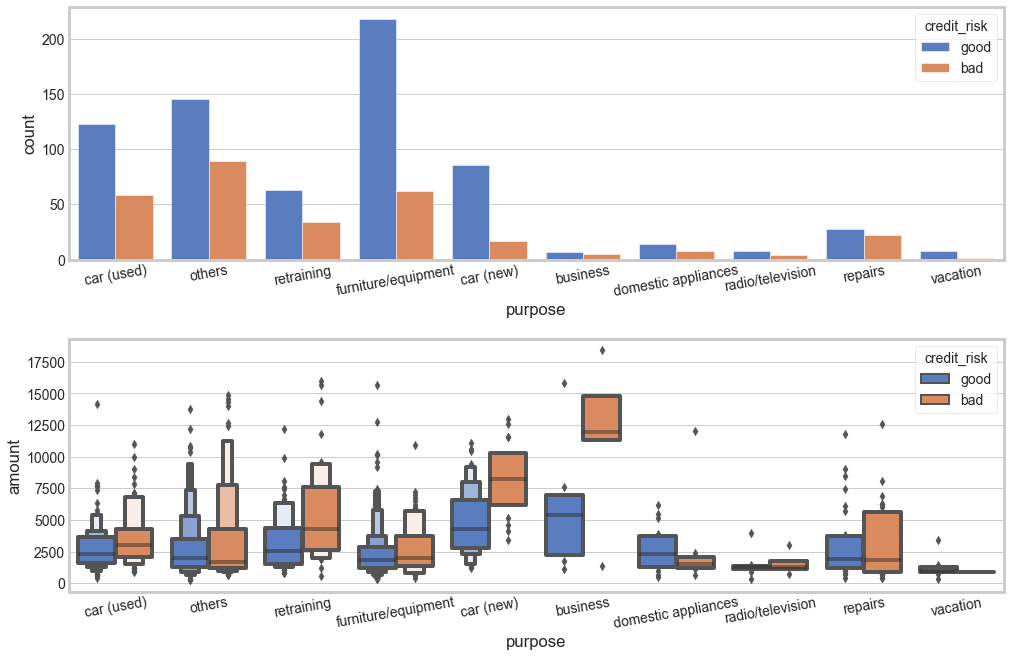

In [7]:
fig, ax =plt.subplots(2,1,figsize=(15,10))
plt.tight_layout(4)

for i in range(2):
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=10)


sns.countplot(psdf['purpose'], hue=psdf['credit_risk'], ax=ax[0], palette='muted');
sns.boxenplot(psdf['purpose'], psdf['amount'], hue=psdf['credit_risk'], ax=ax[1], palette='muted');

### Credit Risk by Housing Analysis
- kebanyakan orang yang mengambil pinjaman adalah orang yang tinggal di tempat sewaan
- urutan dari kecil ke besar dari jumlah pinjaman yang diambil adalah free housing, rent housing, own housing

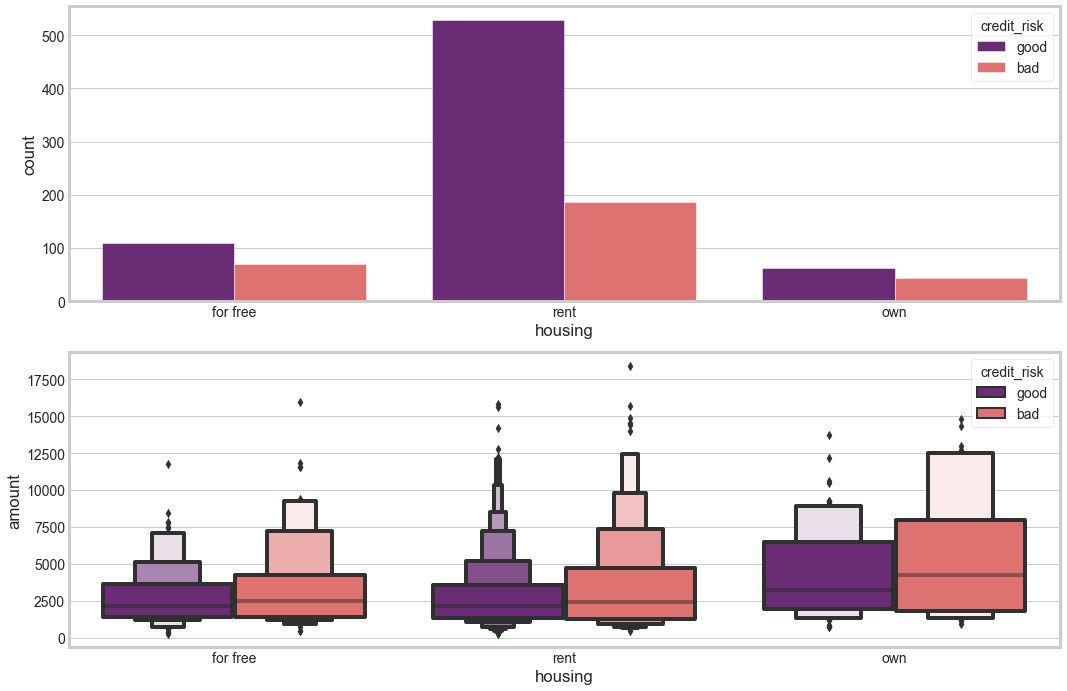

In [8]:
fig, ax =plt.subplots(2,1,figsize=(15,10))
plt.tight_layout(2)

sns.countplot(psdf['housing'], hue=psdf['credit_risk'], ax=ax[0], palette='magma');
sns.boxenplot(psdf['housing'], psdf['amount'], hue=psdf['credit_risk'], ax=ax[1], palette='magma');

# Preprocessing

In [9]:
sdf = sdf.drop('_c0')

In [12]:
cols = sdf.columns
#numerical features
numerical_cols = ['duration', 'age', 'amount']
#categorical features 
categorical_cols = [ele for ele in cols if ele not in numerical_cols]

num_sdf = sdf.select([*numerical_cols])

### Normalize Numerical Features

#### Log Transformation

In [65]:
import pyspark.sql.functions as F
from math import log

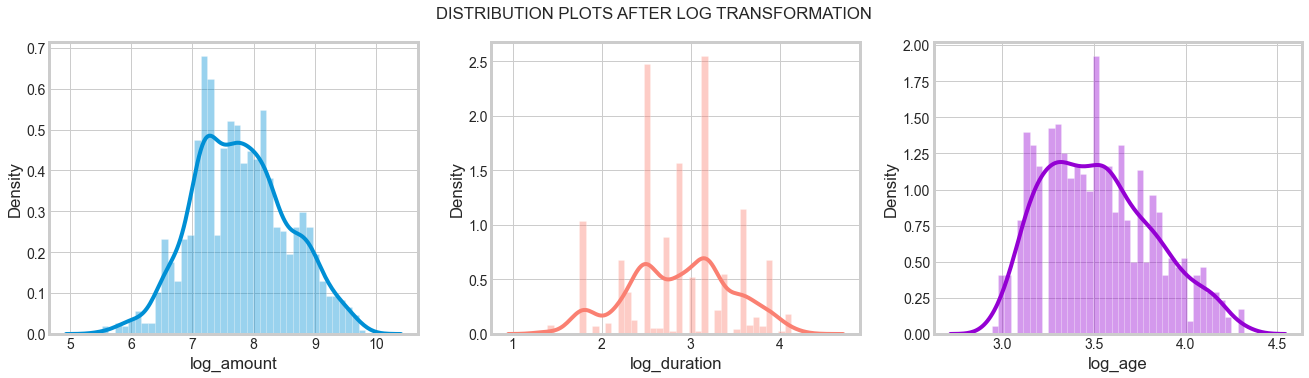

In [13]:
#normalisasi distribusi dengan transformasi log
for col in numerical_cols:
    num_sdf = num_sdf.withColumn("log_"+col, F.log(F.col(col)))
    
num_psdf = num_sdf.toPandas()
fig, ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle('DISTRIBUTION PLOTS AFTER LOG TRANSFORMATION')
sns.distplot(num_psdf['log_amount'], bins=40, ax=ax[0]);
sns.distplot(num_psdf['log_duration'], bins=40, ax=ax[1], color='salmon');
sns.distplot(num_psdf['log_age'], bins=40, ax=ax[2], color='darkviolet');

#### Standart Scalling

In [61]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [15]:
#menyatukan kolom input (log_duration, log_age, log_amount) menjadi satu kolom vektor yang dinamakan feature
features = [ele for ele in num_sdf.columns if ele not in numerical_cols]

assemble=VectorAssembler(inputCols=features, outputCol='features')
assembled_num_sdf=assemble.transform(num_sdf)
assembled_num_sdf.show(2)

+--------+---+------+------------------+-----------------+-----------------+--------------------+
|duration|age|amount|      log_duration|          log_age|       log_amount|            features|
+--------+---+------+------------------+-----------------+-----------------+--------------------+
|      18| 21|  1049|2.8903717578961645|3.044522437723423|6.955592608396297|[2.89037175789616...|
|       9| 36|  2799|2.1972245773362196| 3.58351893845611|7.937017489515453|[2.19722457733621...|
+--------+---+------+------------------+-----------------+-----------------+--------------------+
only showing top 2 rows



In [16]:
#normalisasi skala dengan Standart Scalling
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_num_sdf)
data_scale_output=data_scale.transform(assembled_num_sdf)
data_scale_output.show(2)

+--------+---+------+------------------+-----------------+-----------------+--------------------+--------------------+
|duration|age|amount|      log_duration|          log_age|       log_amount|            features|        standardized|
+--------+---+------+------------------+-----------------+-----------------+--------------------+--------------------+
|      18| 21|  1049|2.8903717578961645|3.044522437723423|6.955592608396297|[2.89037175789616...|[4.96422717493093...|
|       9| 36|  2799|2.1972245773362196| 3.58351893845611|7.937017489515453|[2.19722457733621...|[3.77374361150620...|
+--------+---+------+------------------+-----------------+-----------------+--------------------+--------------------+
only showing top 2 rows



# Clustering

### K-Means

#### Silhouette Method
didapatkan nilai K=3 adalah local maxima dari silhouette score

In [62]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

Text(0, 0.5, 'cost')

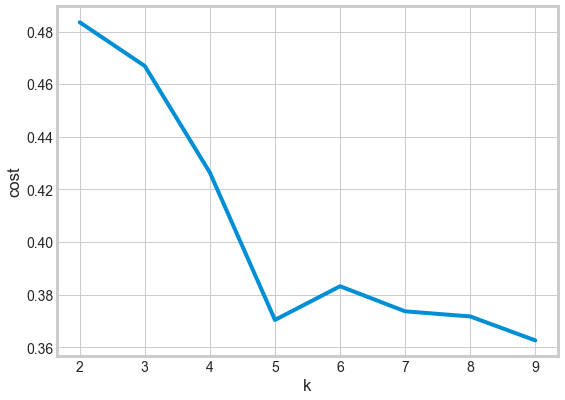

In [17]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    
    score=evaluator.evaluate(output)
    silhouette_score.append(score)

#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [18]:
#Train dengan K=3
KMeans_algo=KMeans(featuresCol='standardized', k=3)
KMeans_fit=KMeans_algo.fit(data_scale_output)
KMeans_result=KMeans_fit.transform(data_scale_output)

# Evaluation

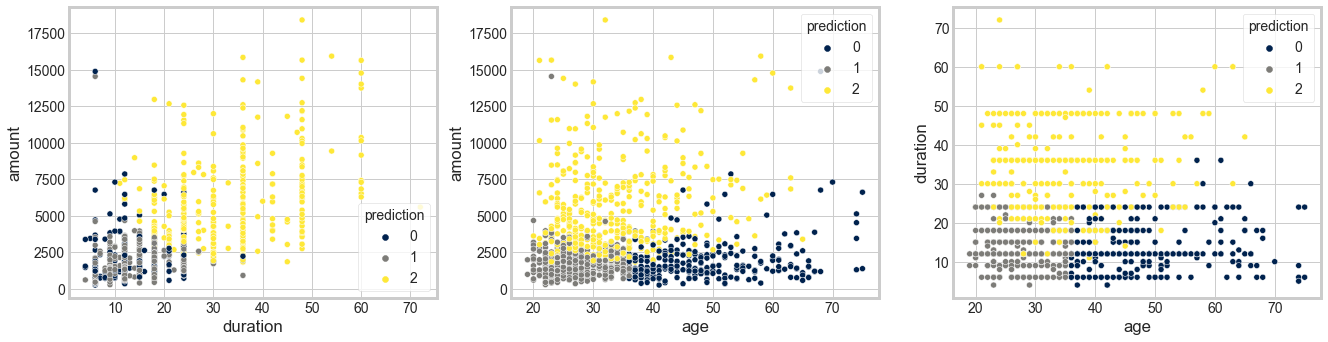

In [59]:
psdf_result = KMeans_result.select( 'age','duration', 'amount', 'prediction').toPandas()

#Scatter plot hasil clustering
fig, ax  = plt.subplots(1,3,figsize=(20,5))
sns.scatterplot(psdf_result['duration'], psdf_result['amount'], hue=psdf_result['prediction'], ax=ax[0], palette='cividis');
sns.scatterplot(psdf_result['age'], psdf_result['amount'], hue=psdf_result['prediction'], ax=ax[1], palette='cividis');
sns.scatterplot(psdf_result['age'], psdf_result['duration'], hue=psdf_result['prediction'], ax=ax[2], palette='cividis');

In [60]:
psdf_result.groupby('prediction').agg(['mean'])

,age,duration,amount
,mean,mean,mean
prediction,,,
0,48.511450,13.843511,1967.038168
1,27.710383,14.390710,1747.090164
2,34.112903,32.282258,5689.379032


# Result

- cluster 0 : orang yang mempunyai usia menengah, cenderung mengambil pinjaman besar dengan durasi yang lama
- cluster 1 : orang yang mempunyai usia muda, cenderung mengambil pinjaman kecil-menengah dengan durasi yang sebentar
- cluster 2 : orang yang mempunyai usia tua, cenderung mengambil pinjaman menengah dengan durasi yang sebentar